<img src ="Images/GatorGlaciologyLogo-01.jpg" width="100" align = "right">

# Non-stationary SGS with k-means clustering
#### Gator Glaciology Lab, University of Florida

Often you may encounter an environment where the spatial statistics are not uniform throughout a region. This is known as non-stationarity. For example, topography can be rough in some places but smooth in others. Here, we demonstrate how to implement SGS with multiple variograms assigned to different regions. We use k-means clustering to divide the data into clusters, and model a separate variogram for each cluster.

In [1]:
# load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import geostatspy.geostats as geostats 
import skgstat as skg
from skgstat import models
import GStatSim as gs
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from sklearn.cluster import KMeans

## Load and plot data

<function matplotlib.pyplot.show(close=None, block=None)>

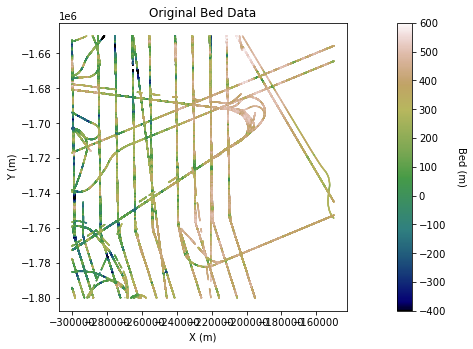

In [2]:
df_bed = pd.read_csv('Data/greenland_test_data.csv') # download data
df_bed = df_bed[df_bed["Bed"] <= 700]  # remove erroneously high values, presumably due to bad bed picks

# plot original data
im = plt.scatter(df_bed['X'],df_bed['Y'], c = df_bed['Bed'], vmin = -400, vmax = 600, marker=".", s = 0.5, 
                 cmap = 'gist_earth')       # scatter plot for location map
plt.title('Original Bed Data')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-400, 600, 11)) # add vertical color bar
cbar.set_label("Bed (m)", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')
plt.show

## Grid and transform data

In [3]:
# Grid data
res = 1000  # resolution
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'X', 'Y', 'Bed', res) # grid data
df_grid = df_grid[df_grid["Z"].isnull() == False]  # remove coordinates with NaNs
df_grid = df_grid.rename(columns = {"Z": "Bed"}) # rename column for consistency

df_grid['Nbed'], tvbed, tnsbed = geostats.nscore(df_grid,'Bed')  # normal score transformation

## Group data into different clusters using K-means clustering

We will break the data into different groups so that each group can be assigned a different variogram. There are many ways the data could be divided. Here we will use k-means clustering with three clusters. The clustering will be based on the coordinates and bed elevation values of the data. The intuition is that data points in similar locations with similar elevation ranges are more likely to have similar variogram parameters.

In [4]:
# K means clustering
kmeans = KMeans(n_clusters = 3, random_state = 0).fit(df_grid[['X','Y','Nbed']])
df_grid['K'] = kmeans.labels_  # make column in dataframe with cluster name

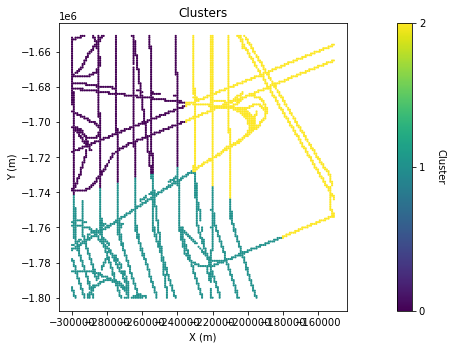

In [5]:
# plot clusters
fig = plt.figure()
im = plt.scatter(df_grid['X'],df_grid['Y'], c = df_grid['K'], vmin = 0, vmax = 2, marker=".", s = 5)       # scatter plot for location map
plt.title('Clusters')                                    # add plot title
plt.xlabel('X (m)')                                                   # set axis labels
plt.ylabel('Y (m)')
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(0, 2, 3)) # add vertical color bar
cbar.set_label("Cluster", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')
plt.show()

In [6]:
# experimental variogram parameters
maxlag = 50000
n_lags = 70 #num of bins

# cluster 0 variogram
df0 = df_grid[df_grid['K'] == 0] # isolate cluster 0 data
coords0 = df0[['X','Y']].values
values0 = df0['Nbed']
V0 = skg.Variogram(coords0, values0, bin_func = "even", n_lags = n_lags, 
                   maxlag = maxlag, normalize=False)


# cluster 1 variogram
df1 = df_grid[df_grid['K'] == 1] # isolate cluster 0 data
coords1 = df1[['X','Y']].values
values1 = df1['Nbed']
V1 = skg.Variogram(coords1, values1, bin_func = "even", n_lags = n_lags, 
                   maxlag = maxlag, normalize=False)


# cluster 2 variogram
df2 = df_grid[df_grid['K'] == 2] # isolate cluster 0 data
coords2 = df2[['X','Y']].values
values2 = df2['Nbed']
V2 = skg.Variogram(coords2, values2, bin_func = "even", n_lags = n_lags, 
                   maxlag = maxlag, normalize=False) 

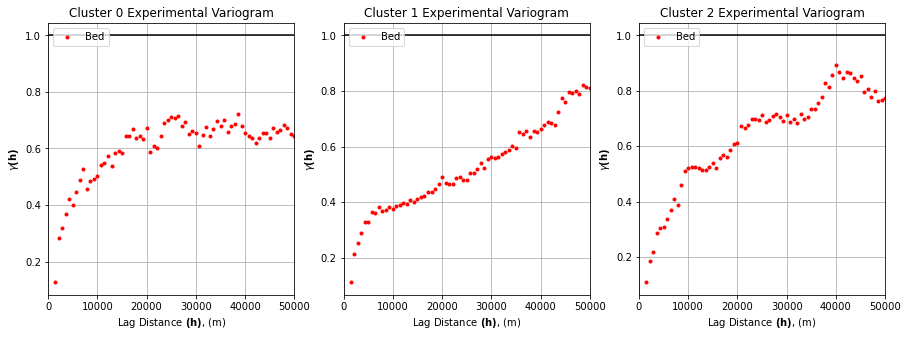

In [7]:
# plot experimental variograms

# create figure
fig = plt.figure(figsize=(15, 5))

# setting values to rows and column variables
fig_rows = 1
fig_columns = 3

# variogram 0
fig.add_subplot(fig_rows, fig_columns, 1)
plt.plot(V0.bins,V0.experimental,'.',color = 'red',label = 'Bed')
plt.plot([0,50000],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Cluster 0 Experimental Variogram')
plt.legend(loc='upper left')
plt.xlim([0,50000])
plt.grid(True)


# variogram 1
fig.add_subplot(fig_rows, fig_columns, 2)
plt.plot(V1.bins,V1.experimental,'.',color = 'red',label = 'Bed')
plt.plot([0,50000],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Cluster 1 Experimental Variogram')
plt.legend(loc='upper left')
plt.xlim([0,50000])
plt.grid(True)


# variogram 2
fig.add_subplot(fig_rows, fig_columns, 3)
plt.plot(V2.bins,V2.experimental,'.',color = 'red',label = 'Bed')
plt.plot([0,50000],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Cluster 2 Experimental Variogram')
plt.legend(loc='upper left')
plt.xlim([0,50000])
plt.grid(True)

In [8]:
# fit variogram model

V0.model = 'exponential' # use exponential variogram model
V1.model = 'exponential' 
V2.model = 'exponential' 

n = 100
lagh = np.linspace(0,30000,n) # create array of evenly spaced lag values to evaluate

range0 = V0.parameters[0]; sill0 = V0.parameters[1]
range1 = V1.parameters[0]; sill1 = V1.parameters[1]
range2 = V2.parameters[0]; sill2 = V2.parameters[1]

y0 = [models.exponential(h, range0, sill0, 0) for h in lagh]
y1 = [models.exponential(h, range1, sill1, 0) for h in lagh]
y2 = [models.exponential(h, range2, sill2, 0) for h in lagh]

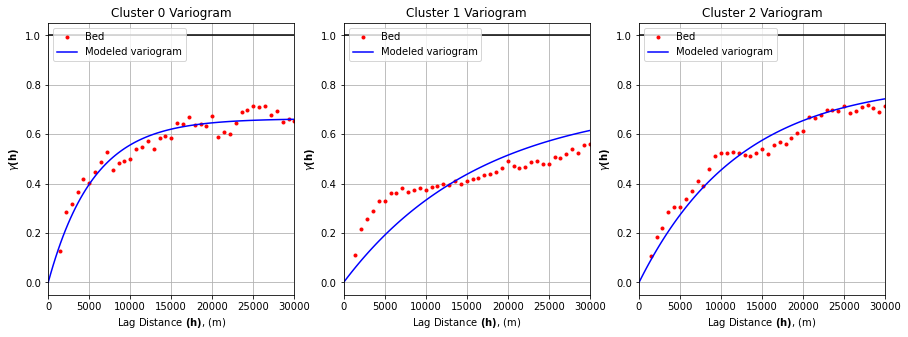

In [9]:
# plot experimental and modeled variograms

# create figure
fig = plt.figure(figsize=(15, 5))

# setting values to rows and column variables
fig_rows = 1
fig_columns = 3

# variogram 0
fig.add_subplot(fig_rows, fig_columns, 1)
plt.plot(V0.bins,V0.experimental,'.',color = 'red',label = 'Bed')
plt.plot(lagh,y0,'-',color = 'blue',label = 'Modeled variogram')
plt.plot([0,30000],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Cluster 0 Variogram')
plt.legend(loc='upper left')
plt.xlim([0,30000])
plt.grid(True)


# variogram 1
fig.add_subplot(fig_rows, fig_columns, 2)
plt.plot(V1.bins,V1.experimental,'.',color = 'red',label = 'Bed')
plt.plot(lagh,y1,'-',color = 'blue',label = 'Modeled variogram')
plt.plot([0,30000],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Cluster 1 Variogram')
plt.legend(loc='upper left')
plt.xlim([0,30000])
plt.grid(True)


# variogram 2
fig.add_subplot(fig_rows, fig_columns, 3)
plt.plot(V2.bins,V2.experimental,'.',color = 'red',label = 'Bed')
plt.plot(lagh,y2,'-',color = 'blue',label = 'Modeled variogram')
plt.plot([0,30000],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Cluster 2 Variogram')
plt.legend(loc='upper left')
plt.xlim([0,30000])
plt.grid(True)

## Simulate with SGS

Next we will implement SGS with multiple variograms. This function is very similar to the original SGS. However, each time a grid cell is simulated, the nearest neighbor k-cluster value is used to select the variogram that is used for that point. This is done as follows:

For each grid cell in a random path:
1. Find the nearest neighbors in the conditioning data, and determine which cluster the nearest point belongs to.
2. Look up the variogram parameters associated with that cluster.
3. Use simple kriging to estimate the mean and variance.
4. Sample from the distribution defined by the mean and variance. This is the simulated value.
5. Append the simulated value to the conditioning data, and give it the same cluster number that was found in Step 2.
6. Repeat steps 1-5 until every grid cell is simulated.

Note that the SGS clustering function (cluster_SGS) uses simple kriging. There is no ordinary kriging option.

In [10]:
# define coordinate grid
xmin = np.min(df_grid['X']); xmax = np.max(df_grid['X'])     # min and max x values
ymin = np.min(df_grid['Y']); ymax = np.max(df_grid['Y'])     # min and max y values

Pred_grid_xy = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)

In [11]:
# make a dataframe with variogram parameters
azimuth = 0
nug = 0 # nugget effect

# define variograms for each cluster
gam0 = [azimuth, nug, range0, range0, 1] # Azimuth, nugget, major range, minor range, sill
gam1 = [azimuth, nug, range1, range1, 1]
gam2 = [azimuth, nug, range2, range2, 1]
df_gamma = pd.DataFrame({'Variogram': [gam0, gam1, gam2]}) # store variogram parameters

In [12]:
# simulate

k = 100 # number of neighboring data points used to estimate a given point 
rad = 50000 # 50 km search radius

sgs = gs.Interpolation.cluster_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', 'K', k, df_gamma, rad) 

# reverse normal score transformation
df_sgs = pd.DataFrame(sgs, columns = ['sgs'])

# transformation parameters
vr = tvbed; vrg = tnsbed; ltail = 1; utail = 1; zmin = -4; zmax = 4; ltpar = -1500; utpar = 1500

# transformation
sgs_trans = geostats.backtr(df_sgs,'sgs',vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar)

100%|████████████████████████████████████| 22500/22500 [03:09<00:00, 118.48it/s]


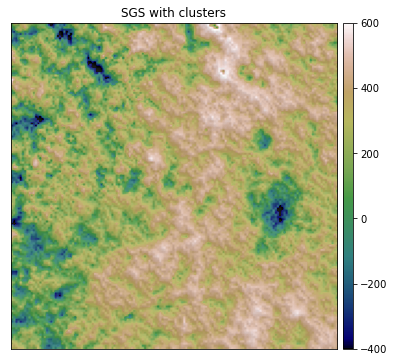

In [13]:
# make hillshade plot for visualizing

# reshape grid
ylen = (ymax + res - ymin)/res
xlen = (xmax + res - xmin)/res
elevation =  np.reshape(sgs_trans, (int(ylen), int(xlen)))
elevation = elevation 

hillshade = es.hillshade(elevation, azimuth = 210, altitude = 10) # hillshade

fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    elevation,
    ax=ax,
    cmap="gist_earth",
    title="SGS with clusters",
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

You can see that some regions appear rougher than others. We can also change the Azimuth and anisotropy in different clusters:

In [14]:
# simulation demo #2

# define variograms for each cluster
gam0 = [45, nug, range0  + 15000, range0, 1] # create anisotropy
gam1 = [azimuth, nug, range1, range1, .6] # change the sill
gam2 = [90, nug, range2 + 15000, range2, 1] # create anisotropy
df_gamma = pd.DataFrame({'Variogram': [gam0, gam1, gam2]}) # store variogram parameters


sgs2 = gs.Interpolation.cluster_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', 'K', k, df_gamma, rad) 

# reverse normal score transformation
df_sgs2 = pd.DataFrame(sgs2, columns = ['sgs2'])

# transformation
sgs2_trans = geostats.backtr(df_sgs2,'sgs2',vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar)

100%|████████████████████████████████████| 22500/22500 [03:29<00:00, 107.37it/s]


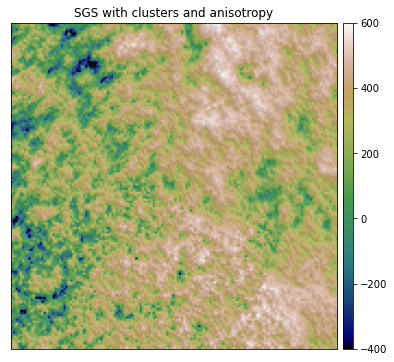

In [15]:
# make hillshade plot for visualizing

# reshape grid
ylen = (ymax + res - ymin)/res
xlen = (xmax + res - xmin)/res
elevation =  np.reshape(sgs2_trans, (int(ylen), int(xlen)))
elevation = elevation 

hillshade = es.hillshade(elevation, azimuth = 210, altitude = 10) # hillshade

fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    elevation,
    ax=ax,
    cmap="gist_earth",
    title="SGS with clusters and anisotropy",
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

There are some visible differences in the topography orientation.